<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# Lab Exercise: Classifying Willow Tree vs. Oak Tree Using CNN

## Objective:
The goal of this lab is to design and implement a Convolutional Neural Network (CNN) to classify between two types of trees: **Willow** and **Oak**. You will work with a dataset that contains images of these two tree classes, divided into subfolders. The exercise will guide you through creating a custom dataset class, designing a CNN model, and writing a training script to perform the binary classification.


## Tasks Breakdown:

### 1. Dataset Preparation
   Create a PyTorch Dataset class to load and preprocess images from the `trees` folder.
     - **Folder Structure:**
       - `trees/Willowtree/` – contains images of Willow trees.
       - `trees/Oaktree/` – contains images of Oak trees.
   - **Objective:** 
     - Write a custom PyTorch Dataset class to:
       - Load images from both folders.
       - Convert images to PyTorch tensors.
       - Apply standard image transformations (e.g., resizing, normalization).
       - Assign labels: 0 for Oak and 1 for Weeping Willow.


### 2. CNN Architecture Design
  Design a CNN architecture for binary classification.
   - **Objective:**
     - Create a PyTorch CNN model that:
       - Contains several convolutional, activation, and pooling layers.
       - Includes fully connected layers at the end for binary classification.


### 3. Training Script
  Implement a training script to train the CNN model on the dataset.
   - **Objective:**
     - Write a script to:
       - Split the dataset into training and validation sets.
       - Define a loss function (binary cross-entropy) and an optimizer (e.g., Adam).
       - Train the model for a specified number of epochs.
       - Evaluate the model on the validation set after each epoch.
       - Output training and validation accuracy at each step.
   

### 4. Inference
  Validate predictions made by the trained model on unseen data




In [2]:
# imports

import matplotlib.pyplot as plt

# svlearn
from svlearn_cnn.trees.tree_dataset import TreeDataset
from svlearn_cnn.trees.preprocess import Preprocessor
from svlearn_cnn import config
from svlearn_cnn.train.visualization_utils import (
    show_image_with_denormalization,
    show_sample_image,
    visualize_classification_training_results,
)

# torch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR


In [3]:
data_dir = config['tree-classification']['data']
results_dir = config['tree-classification']['results']


## 1. Dataset Preparation

Let's load the images from our `data_dir`. The `Preprocessor` does all the preprocessing including loading image paths , label encoding, and spliting the dataset for training and evaluation. 

The preprocess method returns 
 - `train_df` , `test_df` - each containing image paths and their corresponding integer labels 
 - `label_encoder` which we will later use for inference.

In [4]:
preprocessor = Preprocessor()
train_df, val_df, label_encoder = preprocessor.preprocess(data_dir)
print(train_df.head())

     label                                         image_path
225      0       /Users/chandarl/data/trees/Oak/images558.jpg
385      0       /Users/chandarl/data/trees/Oak/images258.jpg
338      0       /Users/chandarl/data/trees/Oak/images302.jpg
458      1  /Users/chandarl/data/trees/WeepingWillow/weepi...
495      1  /Users/chandarl/data/trees/WeepingWillow/metro...


## Image Dataset

### Image Transformations

Let's load the images into our tree dataset and apply some transformations. while transforming images for training we want to create as much variability as possible so that the model can generalize well. We randomly distort the images to make it difficult for the model to overfit. But while evaluating we don't apply these random transformations and try to retain the original image as much as possible.

In [5]:
from torchvision.transforms import v2


# 
train_transform = v2.Compose([
    v2.ToImage(), 
    v2.RandomResizedCrop(224 , scale = (0.5, 1)), # Randomly crop and resize to 224x224
    v2.RandomHorizontalFlip(p=0.5),       # Randomly flip the image horizontally with a 50% chance
    v2.ColorJitter(brightness=0.4 , contrast=0.4, saturation=0.4), # randomly change the brightness , contrast and saturation of images
    v2.ToDtype(torch.float32, scale=True), # ensure te tensor is of float datatype
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize tensor 
    
])

test_transform = v2.Compose([
    v2.ToImage(), 
    v2.Resize(size=(224 , 224)),  # resize all images to a standard size suitable for the cnn model
    v2.ToDtype(torch.float32, scale=True), # ensure te tensor is of float datatype
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize tensor 
])


**Normalization** is an essential preprocessing step in computer vision tasks. It rescales pixel values in an image to a common range, typically between 0 and 1, or -1 and 1. 

Why Normalize?
 - **Consistency**: Images can have different lighting, contrast, or color variations. Normalization reduces the impact of these differences, making images more consistent for the model to learn from.

 - **Prevents Large Gradients**: If the input values are too large, it can cause large gradient values during backpropagation, leading to instability or slow learning. Normalization keeps the gradients in a reasonable range, making the learning process smoother.


In this case, the mean and std (standard deviation) are specific values chosen for typical images from the ImageNet dataset (which we can use for general image datasets too). These values ensure that the pixel values have a mean of 0 and a standard deviation of 1, which helps the CNN learn more effectively.



In [6]:
train_dataset = TreeDataset(train_df, transform=train_transform)
val_dataset = TreeDataset(val_df, transform=test_transform)


### How do the inputs look?

Now that the dataset is created, let's take a sample from the test dataset of an image with an Oak tree. After all these transformations what does the image look like?

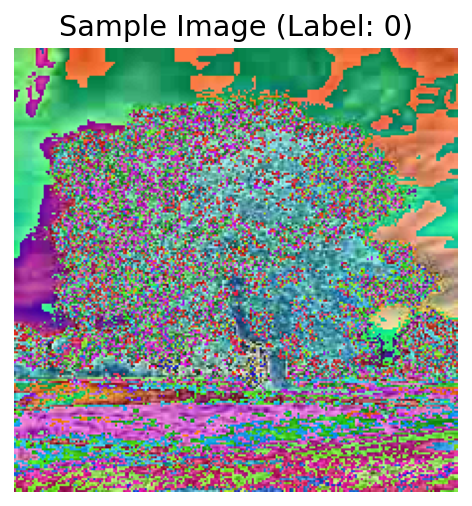

In [7]:
show_sample_image(val_dataset , 3)

The pixel value are not too pleasing to the human eye. This is specifically because of `Normalization`. We can negate this transformation (but retain all other previous transformations )by denormalizing. i.e. we multiply the standard deviation and add the mean back to the pixel value. 

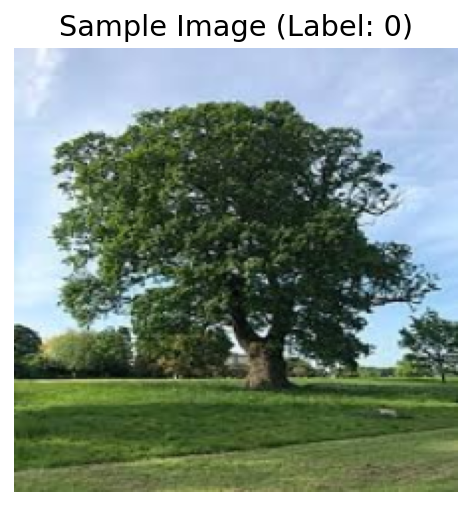

In [8]:
show_image_with_denormalization(val_dataset, 3)

let's also see a sample of a willow tree image, this time from the train dataset. Notice that each time you run the cell below the image is slightly different. This is because of the `train_transform` we applied previously. Every time the dataloader requests a sample, the dataset thus returns a slightly modified version of the image. 

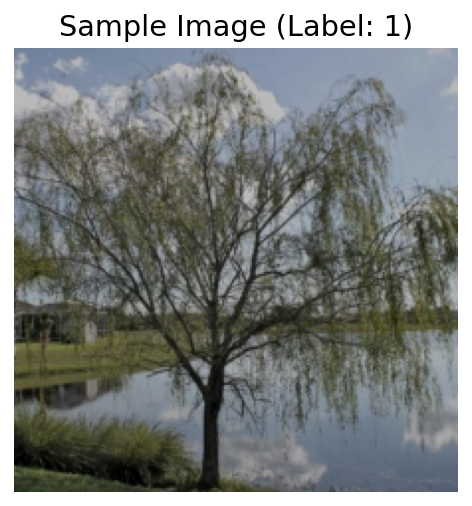

In [9]:
show_image_with_denormalization(train_dataset, 205)

### DataLoaders
We create dataloaders from the train and test dataset. 

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

## 2. CNN Model
Next Let's design a simple CNN architecture that uses the tools we learned in theory class. We want the model (with all it's weights and biases) classify the two types of trees: Weeping Willow and Oak Tree. 

Each block will have a convolution layer,  activation , a batch norm layer and a pooling. 
 - **Convolution Layer** applies filters (small matrices) to input images to detect specific patterns. As the filter slides across the image, it creates feature maps, highlighting the presence of these patterns. Each filter learns to detect different patterns, and deeper layers learn more complex features.
 - **Activation Layer** introduces non-linearity to the network.
 - **Batch Normalization Layer** standardizes the input to a layer by scaling and shifting it, ensuring that the mean is close to 0 and the variance is near 1.
 - **Max Pooling** reduce the spatial dimensions (height and width) of feature maps while preserving the most important information. It makes the network more **robust to minor distortions** or varations in the input

After colvolutions , we enter the familiar territory of fully connected layers which in the end produce outputs representing the model's prediction for both the classes. 


In [11]:
num_classes = 2

model = nn.Sequential(
        # ----------------------------------------------------------------------------------------------------------------------------

        # Convolution Block 1
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),     # ( B , 3 , 224 , 224 ) ->  ( B , 6 , 220 , 220 )
            nn.BatchNorm2d(num_features=6),                                     
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),                                  # ( B , 6 , 220 , 220 ) ->  ( B , 6 , 110 , 110 )

        # ----------------------------------------------------------------------------------------------------------------------------
        # Convolution Block 2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),    # ( B , 6 , 110 , 110 ) ->  ( B , 16 , 106 , 106 )
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                                   # ( B , 16 , 106 , 106 ) ->  ( B , 16 , 53 , 53 )

        # ----------------------------------------------------------------------------------------------------------------------------
        # Convolution Block 3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4),              # ( B , 16 , 53 , 53 ) ->  ( B , 32 , 50 , 50 )                           
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                                   # ( B , 32 , 50 , 50 )   ->  ( B , 32 , 25 , 25 ) 

        # ----------------------------------------------------------------------------------------------------------------------------
            nn.Flatten(), # Change from 2D image to 1D tensor to be able to pass inputs to linear layer
        # ----------------------------------------------------------------------------------------------------------------------------
    
        # Linear Block 1
            nn.Linear(in_features=32 * 25 * 25, out_features=180),
            nn.ReLU(),

        # ----------------------------------------------------------------------------------------------------------------------------
        # Linear block 2
            nn.Linear(in_features=180, out_features=84),
            nn.ReLU(),

        # ----------------------------------------------------------------------------------------------------------------------------
            nn.Linear(in_features=84, out_features=num_classes)
        # ----------------------------------------------------------------------------------------------------------------------------
        )

Next let's define our optimizer to update the model parameters and run our training loop.

In [12]:
optimizer = AdamW(model.parameters(), lr = 0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


## 3. Training Script

We will reuse a classification trainer script we previously used to do binary classification.  The script for training is [here](../../scripts/tree_classification_cnn.py).

We will load the result dataframe that we saved during the training run to plot the results over epochs

In [13]:
import pandas as pd
result = pd.read_csv(f"{results_dir}/cnn-model-trial-2.csv")


Let's print out the results to see the learning progress of our model

In [14]:
print(result)

   epoch  train time  train loss  test loss  train accuracy  test accuracy
0      0   89.977544    0.437877   0.624738        0.812132       0.736842
1      1  184.391297    0.202887   0.151791        0.920176       0.938596
2      2  280.052953    0.147247   0.358952        0.945143       0.877193
3      3  376.920076    0.104900   0.138650        0.960791       0.947368
4      4  474.053858    0.095863   0.466746        0.965714       0.885965
5      5  571.683730    0.070958   0.226026        0.973363       0.929825
6      6  669.982102    0.054431   0.308560        0.981890       0.929825
7      7  765.358406    0.050436   0.241079        0.980659       0.921053
8      8  862.353937    0.042929   0.399713        0.984879       0.894737
9      9  957.797724    0.036387   0.265266        0.987780       0.912281


## 4. Evaluation

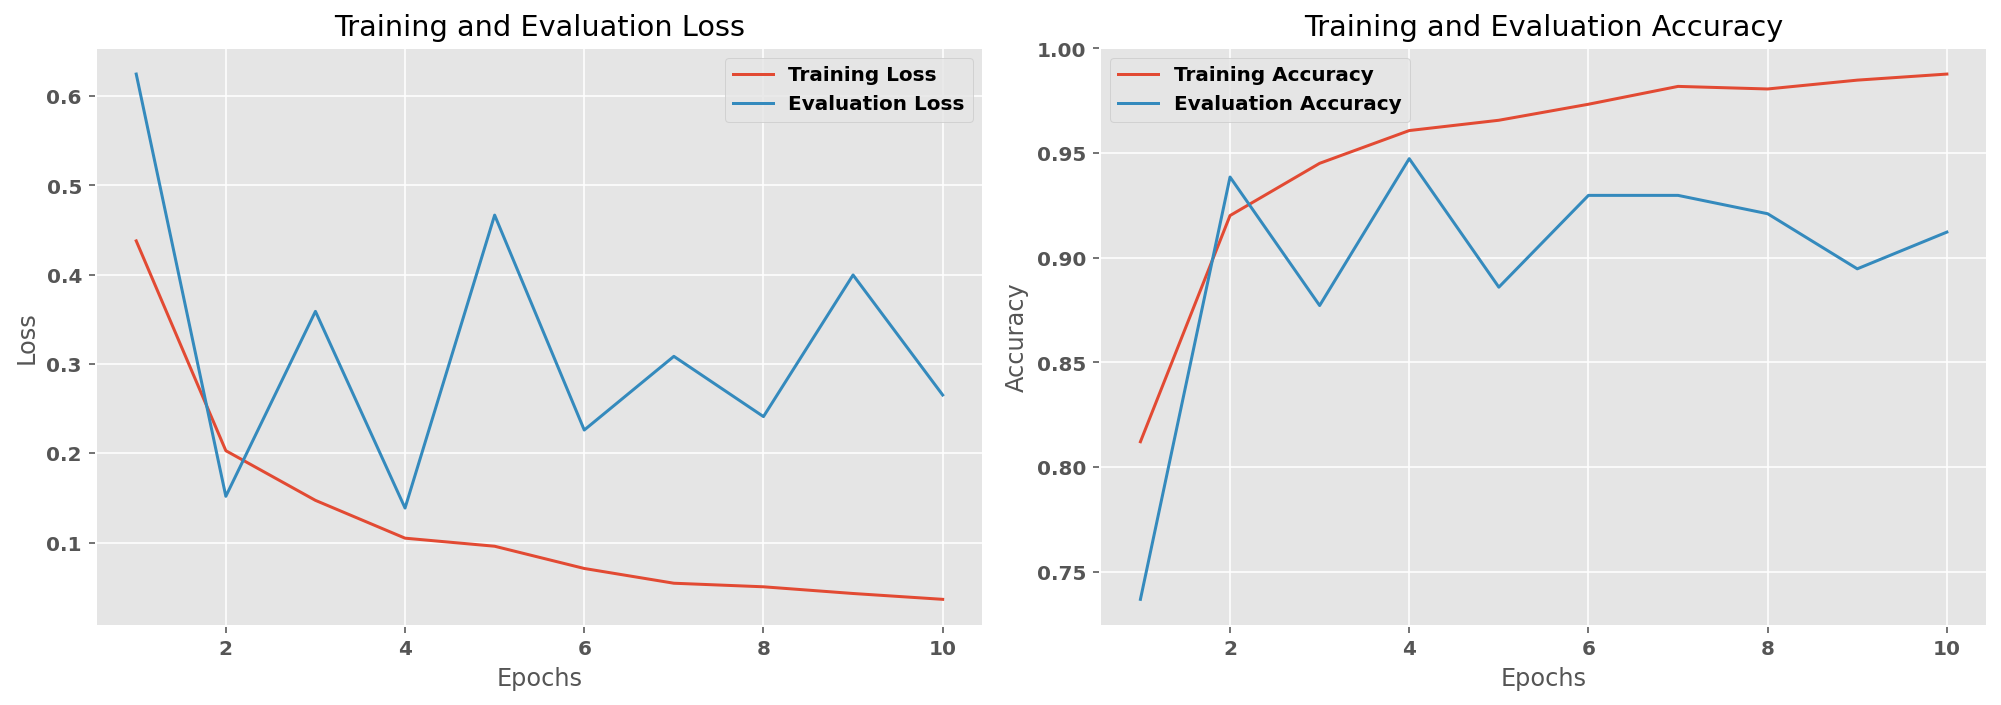

In [15]:

visualize_classification_training_results(result['train loss'] , 
                                          result['test loss'] , 
                                          result['train accuracy'] , 
                                          result['test accuracy'], 
                                          dir_path=results_dir, 
                                          filename="image classification")

## Model Inference

Next let's test out our model with an image. We load the saved model weights and biases from our checkpoint directory and reset our model's paramters to these values.

In [16]:
checkpoint = torch.load(f"{results_dir}/cnn-model-trial-2.pt", weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

### Load an image from file
Download an image from the internet from [here](https://www.nashvilletreeconservationcorps.org/treenews/how-many-oak-tree-varieties) and paste and assign it's path to `img_path`. 

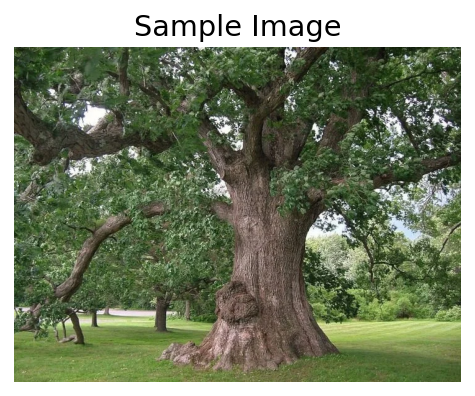

In [17]:
from PIL import Image

img_path = "/Users/chandarl/Downloads/oak.webp"
image = Image.open(img_path).convert("RGB")

# Convert the tensor image back to PIL image for display
image = v2.ToPILImage()(image)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title("Sample Image")
plt.axis('off')  # Hide axis for better visualization
plt.show()

Let's transform to the image to convert to the image into the input that our model expects. By doing `unsqueeze.()` we add an additional dimension that represents a batch (of size 1) 

In [18]:
input = test_transform(image).unsqueeze(0)
input.shape

torch.Size([1, 3, 224, 224])

### Get prediction
Did the model classify the image correctly? 

In [19]:
y_hat = model(input)
prediction = torch.argmax(y_hat)
label_encoder.inverse_transform([prediction])[0]

'Oak'

Likewise, we pick a "Weeping Willow" tree from the internet also [here](https://trees.hillier.co.uk/wp-content/uploads/2023/10/salix-babylonica-pendula-weeping-willow-mature-court-yard-tree-scaled.jpg) and put it through our model.

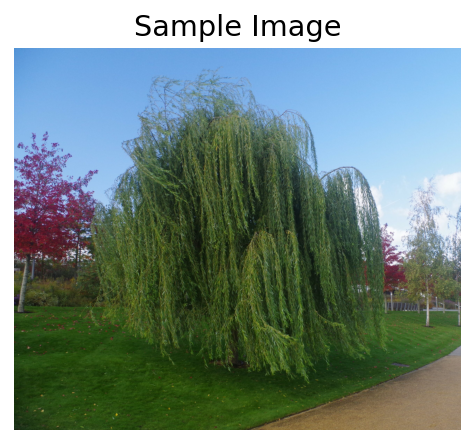

In [20]:
img_path = "/Users/chandarl/Downloads/weeping_willow.jpg"
image = Image.open(img_path).convert("RGB")

# Convert the tensor image back to PIL image for display
image = v2.ToPILImage()(image)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title("Sample Image")
plt.axis('off')  # Hide axis for better visualization
plt.show()

In [21]:
input = test_transform(image).unsqueeze(0)
y_hat = model(input)
prediction = torch.argmax(y_hat)
label_encoder.inverse_transform([prediction])[0]

'WeepingWillow'

## Finetuning a Pretrained model

### VGG16

We designed our CNN model from scratch, let us know use a Pretrained model - VGG and finetune the last few weights of the network with the help of our dataset.

In [22]:
import torchvision.models as models

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Load the VGG16 model
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[6] = nn.Linear(4096, 2) 

The training is handled in the script [here](../../scripts/tree_classification_vgg.py).

As before we load the result dataframe saved during the training to visualize the training over epochs

In [23]:
result = pd.read_csv(f"{results_dir}/vgg-model-01-2.csv")

In [24]:
print(result)

   epoch  train time  train loss  test loss  train accuracy  test accuracy
0      0   73.711742    0.156577   0.125128        0.938901       0.964912
1      1  152.827983    0.093728   0.125660        0.965363       0.956140
2      2  251.439109    0.078663   0.109246        0.972659       0.964912
3      3  352.520689    0.078119   0.120697        0.971604       0.964912
4      4  451.942317    0.074525   0.127729        0.972396       0.956140
5      5  550.471235    0.073696   0.120266        0.972659       0.964912
6      6  646.670455    0.064126   0.141895        0.975473       0.973684
7      7  738.291838    0.067674   0.112172        0.974593       0.956140
8      8  827.137923    0.065555   0.118559        0.976440       0.964912
9      9  914.816327    0.067502   0.147552        0.973714       0.964912


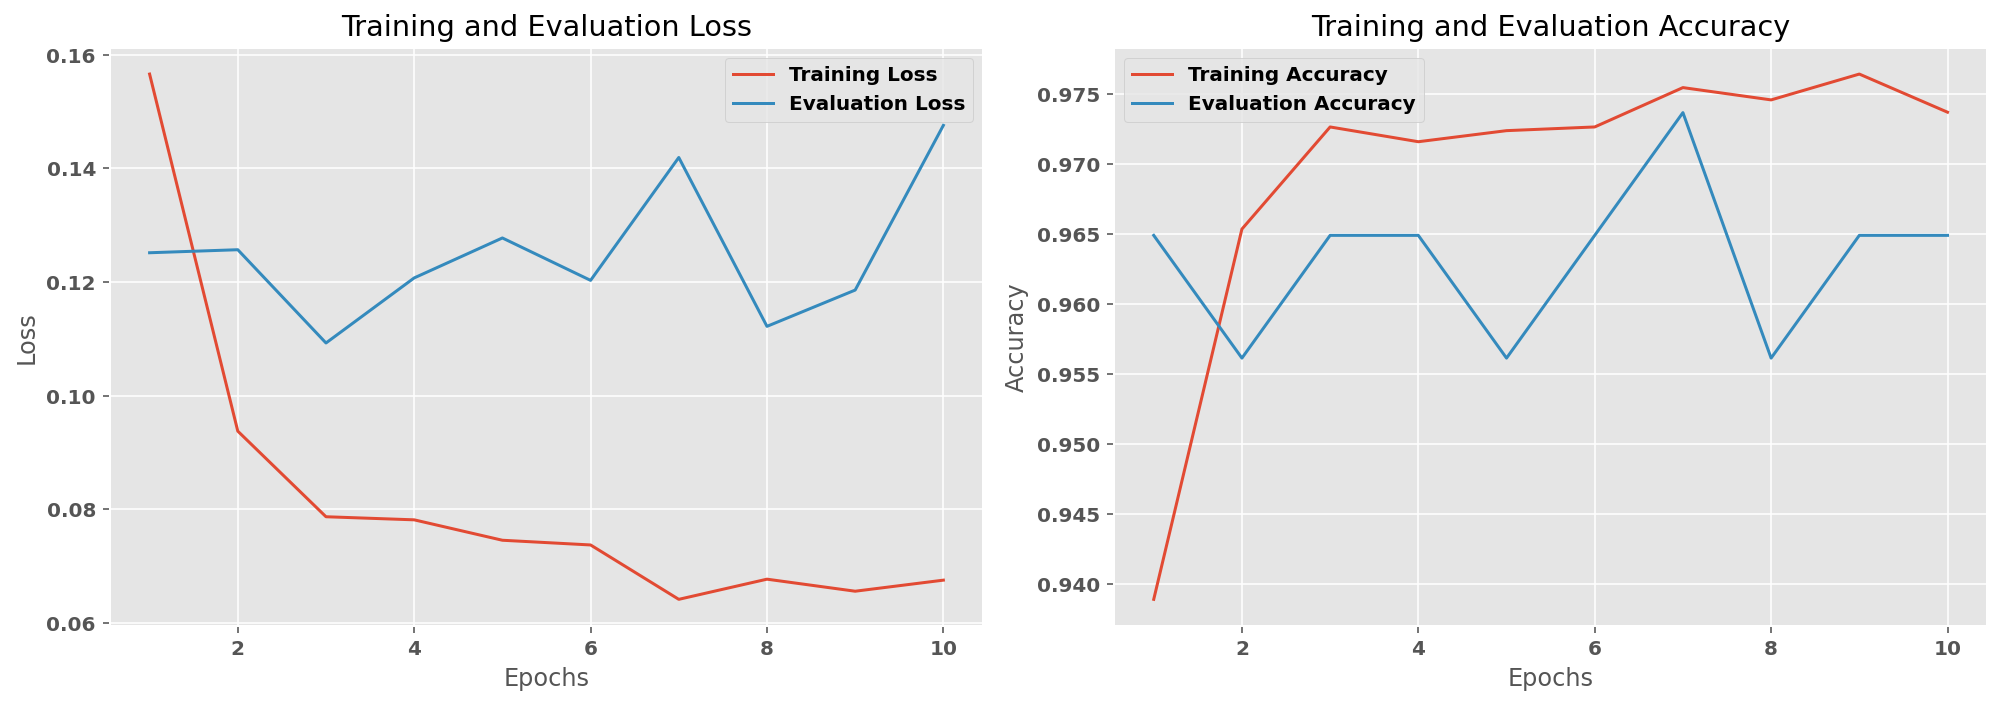

In [25]:
visualize_classification_training_results(result['train loss'] , 
                                          result['test loss'] , 
                                          result['train accuracy'] , 
                                          result['test accuracy'], 
                                          dir_path=results_dir, 
                                          filename="image classification")

We now load the model from the saved model to handle predictions

In [26]:
checkpoint = torch.load(f"{results_dir}/vgg-model-01-2.pt", weights_only=False)

vgg_model.load_state_dict(checkpoint['model_state_dict'])
vgg_model.eval();

In [27]:
img_path = "/Users/chandarl/Downloads/oak.webp"
image = Image.open(img_path).convert("RGB")

# Convert the tensor image back to PIL image for display
image = v2.ToPILImage()(image)
input = test_transform(image).unsqueeze(0)
y_hat = vgg_model(input)
prediction = torch.argmax(y_hat)
label_encoder.inverse_transform([prediction])[0]

'Oak'

In [28]:
img_path = "/Users/chandarl/Downloads/weeping_willow.jpg"
image = Image.open(img_path).convert("RGB")

# Convert the tensor image back to PIL image for display
image = v2.ToPILImage()(image)
input = test_transform(image).unsqueeze(0)
y_hat = vgg_model(input)
prediction = torch.argmax(y_hat)
label_encoder.inverse_transform([prediction])[0]

'WeepingWillow'